In [2]:
import os
import random
import json
import pickle

import tensorflow as tf
import kagglehub as kh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2025-02-22 08:55:27.914931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path = kh.dataset_download("msafi04/iss-docking-dataset")

In [4]:
df = pd.read_csv(os.path.join(path, 'train.csv'))

In [5]:
df.head()

,ImageID,distance,location
0,0,351,"[215, 158]"
1,1,372,"[228, 269]"
2,2,488,"[255, 386]"
3,3,308,"[306, 426]"
4,4,67,"[248, 338]"


In [6]:
n_imgs = len(df)
n_imgs

10000

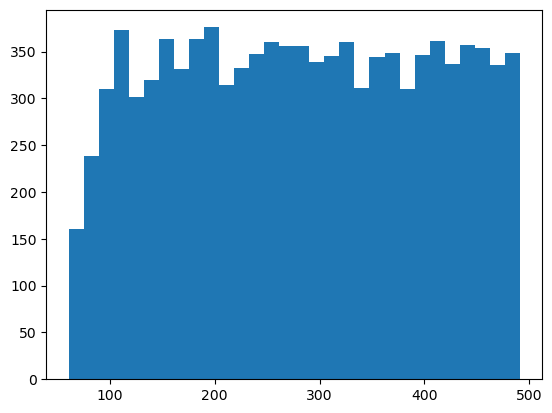

In [7]:
plt.hist(df['distance'], bins=30)
plt.show()

In [8]:
img_width = img_height = 512
batch_size = 32

In [9]:
image_paths = []
for f in os.listdir(os.path.join(path, 'train')):
    if f.startswith('.') or '.jpg' not in f:
        continue
    image_paths.append(os.path.join(path, 'train', f))
len(image_paths)

10000

In [10]:
distances = df.get('distance').tolist()
locations = df.get('location').tolist()

distances[:5]

[351, 372, 488, 308, 67]

In [11]:
image_paths.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

In [12]:
combined_distances = list(zip(image_paths, distances))
combined_locations = list(zip(image_paths, locations))
random.Random(42).shuffle(combined_distances)
random.Random(42).shuffle(combined_locations)

In [13]:
image_paths_distances, distances = zip(*combined_distances)
image_paths_locations, locations = zip(*combined_locations)

In [14]:
train_split = int(0.7*n_imgs)
val_split = train_split + int(0.1*n_imgs)
test_split = val_split + int(0.2*n_imgs)
print(train_split, val_split, test_split)

7000 8000 10000


In [15]:
train_image_paths_distances = np.array(image_paths_distances[:train_split]).flatten()
train_distances = np.array(distances[:train_split]).flatten()
train_image_paths_locations = np.array(image_paths_locations[:train_split]).flatten()
train_locations = locations[:train_split]

val_image_paths_distances = np.array(image_paths_distances[train_split:val_split]).flatten()
val_distances = np.array(distances[train_split:val_split]).flatten()
val_image_paths_locations = np.array(image_paths_locations[train_split:val_split]).flatten()
val_locations = locations[train_split:val_split]

test_image_paths_distances = np.array(image_paths_distances[val_split:test_split]).flatten()
test_distances = np.array(distances[val_split:test_split]).flatten()
test_image_paths_locations = np.array(image_paths_locations[val_split:test_split]).flatten()
test_locations = locations[val_split:test_split]

In [16]:
train_locations = tuple(map(lambda x: tuple(json.loads(x)), train_locations))
train_locations = np.array(train_locations)
train_locations = (train_locations-np.min(train_locations))/(np.max(train_locations)-np.min(train_locations))

val_locations = tuple(map(lambda x: tuple(json.loads(x)), val_locations))
val_locations = np.array(val_locations)
val_locations = (val_locations-np.min(val_locations))/(np.max(val_locations)-np.min(val_locations))

test_locations = tuple(map(lambda x: tuple(json.loads(x)), test_locations))
test_locations = np.array(test_locations)
test_locations = (test_locations-np.min(test_locations))/(np.max(test_locations)-np.min(test_locations))

In [17]:
train_distances = (train_distances-np.min(train_distances))/(np.max(train_distances)-np.min(train_distances))
val_distances = (val_distances-np.min(val_distances))/(np.max(val_distances)-np.min(val_distances))
test_distances = (test_distances-np.min(test_distances))/(np.max(test_distances)-np.min(test_distances))

In [18]:
print(np.max(train_locations))
print(np.min(train_locations))

1.0
0.0


In [19]:
print(np.max(train_distances))
print(np.min(train_distances))

1.0
0.0


In [20]:
def as_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [21]:
train_image_paths_distances = [as_image(_) for _ in train_image_paths_distances]
val_image_paths_distances = [as_image(_) for _ in val_image_paths_distances]
test_image_paths_distances = [as_image(_) for _ in test_image_paths_distances]

train_image_paths_distances = np.array(train_image_paths_distances)
val_image_paths_distances = np.array(val_image_paths_distances)
test_image_paths_distances = np.array(test_image_paths_distances)

In [22]:
print(train_image_paths_distances.shape)

(7000, 512, 512, 3)


In [23]:
net = tf.keras.applications.MobileNetV3Small(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
net.trainable = False

/usr/local/Caskroom/miniconda/base/envs/hai/lib/python3.11/site-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [24]:
# If this is commented out, it is to reduce file length as this output is long
# net.summary()

In [25]:
lr = 1e-4
epochs = 25

flatten = net.output
flatten = tf.keras.layers.Flatten()(flatten)

regression = tf.keras.layers.Dense(64, activation='relu')(flatten)
regression = tf.keras.layers.Dense(32, activation='relu')(regression)
regression = tf.keras.layers.Dense(16, activation='relu')(regression)

# DISTANCE REGRESSION
left_head = tf.keras.layers.Dense(1, activation='relu', name='distance')(regression)

# LOCATION REGRESSION
right_head = tf.keras.layers.Dense(2, activation='relu', name='location')(regression)

model = tf.keras.Model(inputs=net.input, outputs=(left_head, right_head))

losses = { 'distance': 'mean_absolute_error', 'location': 'mean_squared_error' }
loss_weights = { 'distance': 1.0, 'location': 1.0 }

opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss=losses, optimizer=opt, metrics=['mae', 'mse'], loss_weights=loss_weights)

# If this is commented out, it is to reduce file length as this output is long
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 256, 256,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 256, 256,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 257, 257,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 128, 128,  │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        256 │ expanded_conv_sq

 Total params: 10,379,027 (39.59 MB)

 Trainable params: 9,439,907 (36.01 MB)

 Non-trainable params: 939,120 (3.58 MB)

None


In [26]:
train_targets = { 'distance': train_distances, 'location': train_locations }
test_targets = { 'distance': test_distances, 'location': test_locations }
val_targets = { 'distance': val_distances, 'location': val_locations }

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model_2.keras', monitor='val_loss', save_best_only=True)]
history = model.fit(train_image_paths_distances, train_targets,
                    validation_data = (val_image_paths_distances, val_targets),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 1329s 6s/step - distance_loss: 0.2943 - distance_mae: 0.2943 - location_loss: 0.2902 - location_mse: 0.2902 - loss: 0.5845 - val_distance_loss: 0.1398 - val_distance_mae: 0.1397 - val_location_loss: 0.1388 - val_location_mse: 0.1385 - val_loss: 0.2783
Epoch 2/25
219/219 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - distance_loss: 0.1334 - distance_mae: 0.1334 - location_loss: 0.1347 - location_mse: 0.1347 - loss: 0.2680 - val_distance_loss: 0.1141 - val_distance_mae: 0.1140 - val_location_loss: 0.1344 - val_location_mse: 0.1341 - val_loss: 0.2482
Epoch 3/25
 58/219 ━━━━━━━━━━━━━━━━━━━━ 3:09 1s/step - distance_loss: 0.1157 - distance_mae: 0.1157 - location_loss: 0.1277 - location_mse: 0.1277 - loss: 0.2434

KeyboardInterrupt: 

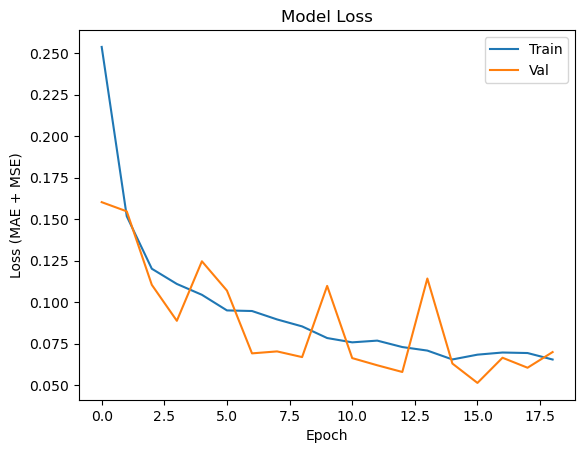

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss (MAE + MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('loss2.png')
plt.show()


In [ ]:
history.history.keys()

dict_keys(['distance_loss', 'distance_mae', 'location_loss', 'location_mse', 'loss', 'val_distance_loss', 'val_distance_mae', 'val_location_loss', 'val_location_mse', 'val_loss'])

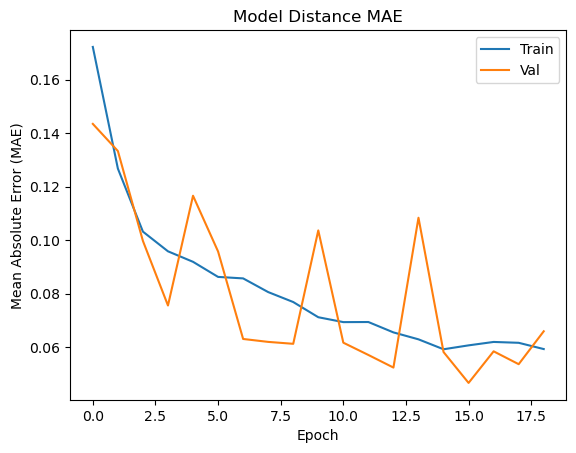

In [ ]:
plt.plot(history.history['distance_mae'])
plt.plot(history.history['val_distance_mae'])
plt.title('Model Distance MAE')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('mae2.png')
plt.show()

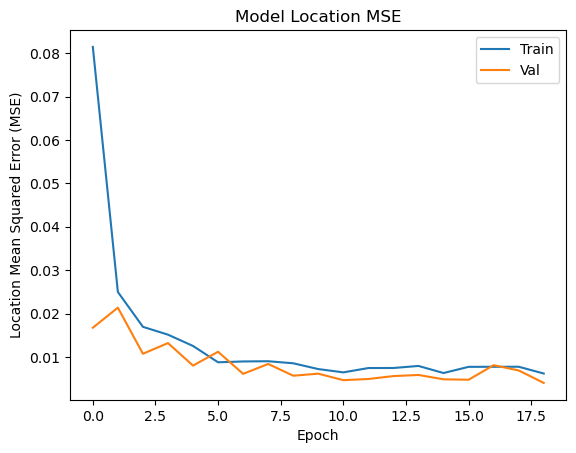

In [ ]:
plt.plot(history.history['location_mse'])
plt.plot(history.history['val_location_mse'])
plt.title('Model Location MSE')
plt.ylabel('Location Mean Squared Error (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('mse2.png')
plt.show()

In [ ]:
model.evaluate(test_image_paths_distances, test_targets)

63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - distance_loss: 0.0669 - distance_mae: 0.0669 - location_loss: 0.0045 - location_mse: 0.0045 - loss: 0.0714


[0.07052291929721832,
 0.06604497134685516,
 0.004402212332934141,
 0.06612737476825714,
 0.0043955412693321705]